In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
import warnings


warnings.filterwarnings("ignore")

/home/dmalberto/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/home/dmalberto/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


In [2]:
df = pd.read_csv('BTC-USD.csv', parse_dates=['Date'])
train = df.loc[df['Date'] < '2022-05-01',['Date','Close']].set_index('Date').sort_index()

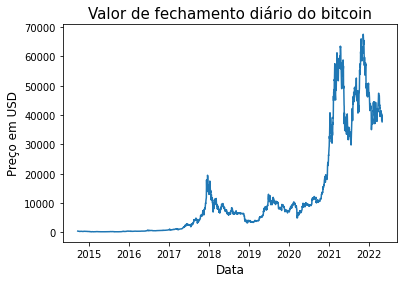

In [3]:
plt.rcParams["figure.figsize"] = (15,5)
plt.plot(train)

plt.xlabel('Data', fontsize=12)
plt.ylabel('Preço em USD', fontsize=12)
plt.title("Valor de fechamento diário do bitcoin", fontsize=15)

plt.show()

In [4]:

def test_stationarity(x):
   #Determing rolling statistics
   rolmean = x.rolling(window=22,center=False).mean()
   rolstd = x.rolling(window=12,center=False).std()
   
   #Plot rolling statistics:
   plt.plot(x, color='blue',label='Original')
   plt.plot(rolmean, color='red', label='Rolling Mean')
   plt.plot(rolstd, color='black', label = 'Rolling Std')
   plt.legend(loc='best')
   plt.title('Rolling Mean & Standard Deviation')
   plt.show(block=False)
   
   #Perform Dickey Fuller test    
   result=adfuller(x)

   print('ADF Stastistic: %f'%result[0])
   print('p-value: %f'%result[1])
   print("The graph is non stationery" if result[0]> result[4]['1%'] else "The graph is stationery")
   print('Critical values:')
   for key,value in result[4].items():
      print('\t%s: %.3f ' % (key, value))

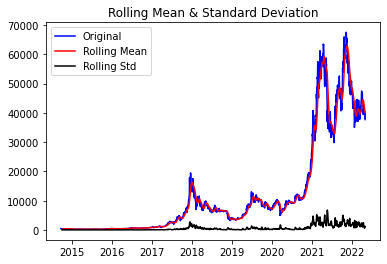

ADF Stastistic: -1.267099
p-value: 0.644087
The graph is non stationery
Critical values:
	1%: -3.433 
	5%: -2.863 
	10%: -2.567 


In [5]:
ts = train['Close']
test_stationarity(ts)

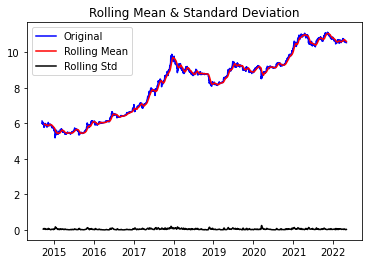

ADF Stastistic: -0.597045
p-value: 0.871648
The graph is non stationery
Critical values:
	1%: -3.433 
	5%: -2.863 
	10%: -2.567 


In [6]:
ts_log = np.log(ts)
test_stationarity(ts_log)

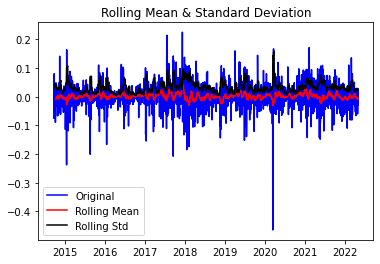

ADF Stastistic: -15.892515
p-value: 0.000000
The graph is stationery
Critical values:
	1%: -3.433 
	5%: -2.863 
	10%: -2.567 


In [7]:
ts_log_diff = ts_log - ts_log.shift()
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff)

In [8]:
def plot_fitted(results, serie_diff):
    plt.plot(serie_diff)
    plt.plot(results.fittedvalues, color='yellow')
    rss = sum(
        (results.fittedvalues - serie_diff[1:])**2)
    print('RSS: %.7f' % rss)
    plt.title('RSS: %.7f' % rss)
    plt.show()

### AR

RSS: 6.3915342


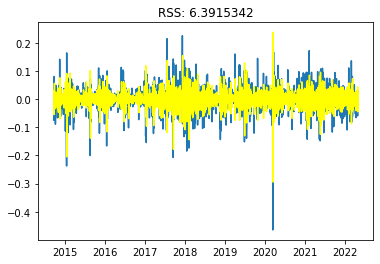

In [9]:
model = ARIMA(ts_log_diff, order=(1, 1, 0))
results_AR = model.fit(disp=-1)
plot_fitted(results_AR, ts_log_diff)

### MA

RSS: 8.2676857


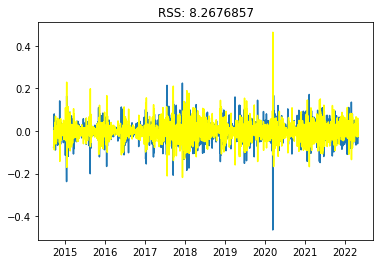

In [10]:
model = ARIMA(ts_log_diff, order=(0,1,1))
results_MA = model.fit(disp=-1)
plot_fitted(results_MA, ts_log_diff)

### ARIMA

RSS: 7.0887070


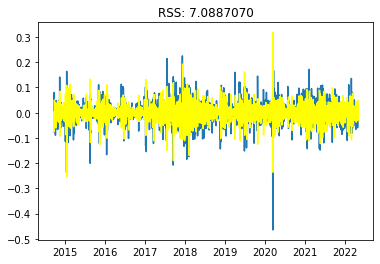

In [11]:
model = ARIMA(ts_log_diff, order=(2, 1, 0))
results_ARIMA = model.fit(disp=-1)
plot_fitted(results_ARIMA, ts_log_diff)

In [12]:
# # Divide into train and test
# def pred_value(t):
#     model = ARIMA(ts_log_diff, order=(1, 1, 0))
#     results_AR = model.fit(disp=-1)
#     print(results_AR.summary())
#     output = results_AR.forecast()
#     train_arima.append(t)
#     return float(np.exp(output[0]))

# size = int(len(ts_log) * 0.8)
# train_arima = ts_log_diff[:size].to_list()
# test_arima = ts_log_diff[size:]

# # Calculate the predictions
# results = pd.DataFrame({'test': test_arima.to_list()}, index=test_arima.index)
# results['original'] = np.exp(results['test'])
# results['prediction'] = results['test'].map(lambda t:pred_value(t))
# results['error'] = results['prediction'] - results['original']
# results['error_mean'] = (abs(results['prediction'] - results['original'])) * 100 / results['original']

# # Print the results values
# print(results)

# # Error. 
# print('MFE: %.2f' % (results['error'].mean()))
# print('MAE: %.2f' % (results['error'].abs().mean()))
# print('MAPE: %.3f' % (round(results['error_mean'].mean(),2)), '%')

# # Plot the results
# plt.figure(figsize=(15,5))
# plt.plot(results.index, results['original'], color = 'green')
# plt.plot(results.index, results['prediction'], color= 'orange')
# plt.title('Expected Vs Predicted Views Forecasting')
# plt.xlabel('Day')
# plt.ylabel('Closing Price')
# plt.legend({'Orginal','Predicted'})
# plt.show()

In [13]:
from math import sqrt
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_error

def check_erro(orig, prev, nome_col='', nome_indice=''):
    
    vies = np.mean(orig - prev)
    mse = mean_squared_error(orig, prev)
    rmse = sqrt(mean_squared_error(orig, prev))
    mae = mean_absolute_error(orig, prev)
    mape = np.mean(np.abs((orig - prev) / orig)) * 100
    
    grupo_erro = [vies, mse, rmse, mae, mape]
    serie = pd.DataFrame(grupo_erro, index=['VIÉS','MSE','RMSE','MAE', 'MAPE'], columns=[nome_col])
    serie.index.name = nome_indice
    
    return serie

Printing Predicted vs Expected Values...


predicted = 8737.065929,   expected = 8929.038086,   error = 2.149976  %
predicted = 8945.345638,   expected = 8942.808594,   error = 0.028370  %
predicted = 8953.223695,   expected = 8706.245117,   error = 2.836798  %
predicted = 8718.117989,   expected = 8657.642578,   error = 0.698521  %
predicted = 8674.534412,   expected = 8745.894531,   error = 0.815927  %
predicted = 8760.594121,   expected = 8680.875977,   error = 0.918319  %
predicted = 8692.294514,   expected = 8406.515625,   error = 3.399493  %
predicted = 8418.823378,   expected = 8445.434570,   error = 0.315096  %
predicted = 8463.044365,   expected = 8367.847656,   error = 1.137649  %
predicted = 8379.377988,   expected = 8596.830078,   error = 2.529445  %
predicted = 8612.447830,   expected = 8909.819336,   error = 3.337571  %
predicted = 8921.169243,   expected = 9358.589844,   error = 4.674001  %
predicted = 9370.422621,   expected = 9316.629883,   error = 0.577384  %
predicte

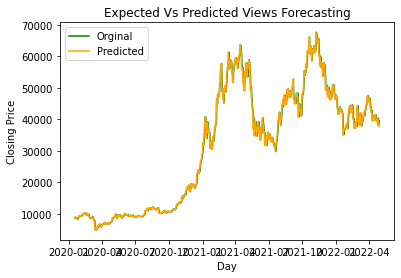

In [14]:
size = int(len(ts_log)*0.7)
# Divide into train and test
train_arima, test_arima = ts_log[:size], ts_log[size:]
history = list(train_arima)
predictions = []
originals = []
error_list = []
pred_list = []
original_list = []

print('Printing Predicted vs Expected Values...')
print('\n')
# We go over each value in the test set and then apply ARIMA model and calculate the predicted value. We have the expected value in the test set therefore we calculate the error between predicted and expected value 
for t in range(len(test_arima)):
    model = ARIMA(history, order=(2, 1, 0))
    model_fit = model.fit(disp=-1)

    output = model_fit.forecast()

    pred_value = output[0]


    original_value = test_arima[t]
    history.append(original_value)

    original_value = test_arima[t]
    pred_value = np.exp(pred_value)


    original_value = np.exp(original_value)

    # Calculating the error
    error = ((abs(pred_value - original_value)) / original_value) * 100
    error_list.append(error)
    pred_list.append(pred_value[0])
    original_list.append(original_value)
    print('predicted = %f,   expected = %f,   error = %f ' % (pred_value, original_value, error), '%')

    predictions.append(float(pred_value))
    originals.append(float(original_value))

print('\n Mean Error in Predicting Test Case Articles : %f ' % (sum(error_list)/float(len(error_list))), '%')
test_day = test_arima.index
labels={'Orginal','Predicted'}
plt.plot(test_day, predictions, color= 'green')
plt.plot(test_day, originals, color = 'orange')
plt.title('Expected Vs Predicted Views Forecasting')
plt.xlabel('Day')
plt.ylabel('Closing Price')
plt.legend(labels)
plt.show()

In [17]:
from math import sqrt
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_error

def check_erro(orig, prev, nome_col='Resultado', nome_indice='Métricas'):
    errors = [pred_list[i] - original_list[i] for i in range(len(pred_list))]
    aux_mape = [(errors[i]) / orig[i] for i in range(len(orig))]
    
    vies = np.mean(errors)
    mse = mean_squared_error(orig, prev)
    rmse = sqrt(mean_squared_error(orig, prev))
    mae = mean_absolute_error(orig, prev)
    mape = np.mean(np.abs(aux_mape)) * 100
    
    grupo_erro = [ vies, mse, rmse, mae, mape]
    serie = pd.DataFrame(grupo_erro, index=['MFE','MSE','RMSE','MAE', 'MAPE'], columns=[nome_col])
    serie.index.name = nome_indice
    
    return serie

In [18]:
check_erro(original_list, pred_list)

,Resultado
Métricas,
MFE,2.110000e+01
MSE,1.923451e+06
RMSE,1.386886e+03
MAE,8.670231e+02
MAPE,2.671510e+00
